In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## ODE integrators ##

Many problems in physics reduce to solving ordinary differential equations (see, e.g., all of mechanics!) and frequently these are initial value problems.  While there is an enormous and sophisticated theory and practice for ODE integration, for much of the time you can in fact get by with just a couple of stand-bys.

For definiteness let us imagine we are interested in the solution of the ODE
$$
\frac{d\vec{y}}{dt} = f(t,\vec{y})
$$
given (well posed) initial values $\vec{y}(t_0)$.  We imagine taking steps, of size $h$, in $t$ and updating $\vec{y}$ through a sequence of values $\vec{y}_0$, $\vec{y}_1$, ..., etc.

First off, if you know something about the natural timescale of your ODE and you know it's not going to change dramatically then it's hard to do better than [fourth order Runge-Kutta method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods), colloquially known as [RK4](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods).  This should be in everyone's toolkit.

In [2]:
def deriv(t,y):
    """Returns dy/dt for a cosine/sine system as an example."""
    dydt    = np.zeros_like(y)
    dydt[0] = -y[1]
    dydt[1] =  y[0]
    return(dydt)
    #

def rk4(t,y,h):
    """Makes a single RK4 step."""
    k1 = h * deriv(t      ,y)
    k2 = h * deriv(t+0.5*h,y+k1/2)
    k3 = h * deriv(t+0.5*h,y+k2/2)
    k4 = h * deriv(t+    h,y+k3)
    return( (t+h,y+(k1+2*k2+2*k3+k4)/6.0) )

Note that the limit that $f(t,\vec{y})$ is independent of $\vec{y}$ this becomes Simpson's rule for integration which may make RK4 easier to remember.

Error at end is 0.054379%


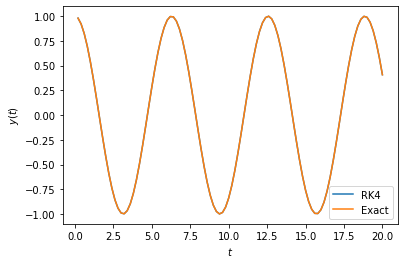

In [3]:
# Let's test it ...
tarr= []
yarr= []
#
h   = 0.2
t,y = 0.0,np.array([1.0,0.0])
for i in range(100):
    t,y = rk4(t,y,h)
    tarr.append(t)
    yarr.append(y[0])
tarr = np.array(tarr)
yarr = np.array(yarr)
#
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(tarr,yarr,label='RK4')
ax.plot(tarr,np.cos(tarr),label='Exact')
ax.legend()
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
#
ap = yarr[-1]
ex = np.cos(tarr[-1])
print("Error at end is {:f}%".format(100*(ap-ex)/ex))

This is actually pretty good performance, and if you know something about the period then you can dial the accuracy you want by just setting $h$ appropriately.

### Adaptive steps ###

For a more general case, one wants to use some form of adaptive stepsize control.  Unless you have an external way of guessing a good stepsize (and sometimes you do!) then the standard methods are

1) try a step with size $h$ and $h/2$, compare the results and decide whether to keep it or not OR

2) embed a lower order integrator inside your higher order one and compare the two at the end of the step.

A very common example of (2) is a combined 4th order and 5th order Runge-Kutta.  A cute example which only involves 3 function evaluations per step is a combination of 2nd and 3rd order integrators known as [Bogacki Shampine](https://en.wikipedia.org/wiki/Bogacki%E2%80%93Shampine_method).

In [4]:
def ode23(t,y,h,k4):
    """A single step of the Bogacki Shampine method -- note the last
    step of this method computes a "k4" which equals the "k1" of the
    next step, so we take it in and return it.  The next step would
    be determined by the value of the error you get back (i.e. the
    difference between "y" and "z")."""
    y0 = y
    k1 = k4
    k2 = h * deriv(t+0.50*h,y+0.50*k1)
    k3 = h * deriv(t+0.75*h,y+0.75*k2)
    y  = y + (2*k1+3*k2+4*k3)/9.0
    k4 = h * deriv(t+h,y)
    z  = y0+ (7*k1+6*k2+8*k3+3*k4)/24.0
    return( (t+h,y,z,k4) )

Error at end is -0.891672%


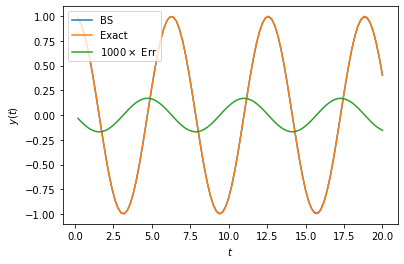

In [5]:
# Let's test it ...
tarr= []
yarr= []
earr= []
#
h   = 0.2
t,y = 0.0,np.array([1.0,0.0])
k1  = h*deriv(t,y)
for i in range(100):
    t,y,z,k1 = ode23(t,y,h,k1)
    tarr.append(t)
    yarr.append(y[0])
    earr.append(y[0]-z[0])
tarr = np.array(tarr)
yarr = np.array(yarr)
earr = np.array(earr)
#
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(tarr,yarr,label='BS')
ax.plot(tarr,np.cos(tarr),label='Exact')
ax.plot(tarr,1e3*earr,label=r'$1000\times$ Err')
ax.legend()
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
#
ap = yarr[-1]
ex = np.cos(tarr[-1])
print("Error at end is {:f}%".format(100*(ap-ex)/ex))

One advantage of this low-order method is that if the step size is changing rapidly and unexpectedly you are only making 3 function evaluations that you throw away.  The disadvantage if that if the ODE is mostly well behaved then you're not getting the full power of a high-order integrator.

Here's an example of how one implements the adaptive stepsize:

In [6]:
# Now do adaptive step sizes using a wrapper.
abstol = 1e-5
reltol = 1e-7
#
tarr,yarr = [],[]
#
h   = 0.2 # A first guess to get us going ...
t,y = 0.0,np.array([1.0,0.0])
k1  = h*deriv(t,y)
while t<2.0:
    tnew,ynew,znew,k1new = ode23(t,y,h,k1)
    tol = abstol + np.max([np.abs(ynew[0]),np.abs(znew[0])]) * reltol
    err = np.abs(ynew[0]-znew[0])
    print("{:.3f} {:12.4e} {:12.4e} {:12.4e}".format(t,h,err,tol))
    if err<tol:
        t,y,z,k1 = tnew,ynew,znew,k1new
        if err<0.2*tol:
            # If we're doing too well, allow step to grow.
            fac = (tol/err)**(0.3333)
            print("-- accepting step, changing h with fac={:f}".format(fac))
            h  *= fac
            k1 *= fac
    else:
        fac = 0.9*(tol/err)**(0.3333)
        print("-- redoing step with fac={:f}".format(fac))
        h  *= fac
        k1 *= fac
    tarr.append(t)
    yarr.append(y[0])
tarr = np.array(tarr)
yarr = np.array(yarr)
#
ap = yarr[-1]
ex = np.cos(tarr[-1])
print("Took {:d} steps.".format(tarr.size))
print("Error at end is {:f}%".format(100*(ap-ex)/ex))

0.000   2.0000e-01   3.3333e-05   1.0098e-05
-- redoing step with fac=0.604476
0.000   1.2090e-01   4.4503e-06   1.0099e-05
0.121   1.2090e-01   8.8573e-06   1.0097e-05
0.242   1.2090e-01   1.3135e-05   1.0093e-05
-- redoing step with fac=0.824361
0.242   9.9661e-02   6.9332e-06   1.0094e-05
0.341   9.9661e-02   8.8419e-06   1.0090e-05
0.441   9.9661e-02   1.0663e-05   1.0086e-05
-- redoing step with fac=0.883461
0.441   8.8047e-02   7.2032e-06   1.0086e-05
0.529   8.8047e-02   8.2590e-06   1.0082e-05
0.617   8.8047e-02   9.2507e-06   1.0076e-05
0.705   8.8047e-02   1.0171e-05   1.0070e-05
-- redoing step with fac=0.897021
0.705   7.8980e-02   7.2703e-06   1.0071e-05
0.784   7.8980e-02   7.8227e-06   1.0065e-05
0.863   7.8980e-02   8.3264e-06   1.0059e-05
0.942   7.8980e-02   8.7782e-06   1.0052e-05
1.021   7.8980e-02   9.1752e-06   1.0045e-05
1.100   7.8980e-02   9.5151e-06   1.0038e-05
1.179   7.8980e-02   9.7956e-06   1.0031e-05
1.258   7.8980e-02   1.0015e-05   1.0023e-05
1.337   7

### Very low order integrators ###

Sometimes it is better to use a low order ODE integrator and just hammer the number of steps, rather than a higher order integrator that requires fewer function calls.  The lowest order method is Euler's method, which is normally introduced primarily to show how bad it is!  Here let's look at two methods which are second order and involve two derivative evaluations.

### Midpoint method ###

Perhaps the most obvious second order method (related to the "leap frog" method for symplectic systems -- see below) is the [midpoint method](https://en.wikipedia.org/wiki/Midpoint_method).  Here we use Euler's method to get an estimate for $\vec{y}$ at the midpoint of the interval, then evaluate $f$ there and use that value to take the step.
$$
  y_{n+1} = y_n + h\,f\left(t_n+\frac{h}{2},y_n+\frac{h}{2}f(t_n,y_n)\right)
$$
We can write this in a way slightly more reminiscent of the Runge-Kutta family of integrators by saying
$$
  k_1 = f(t_n,y_n) \quad , \quad
  y_{n+1} = y_n + h\,f\left(t_n+\frac{1}{2}h,y_n+\frac{1}{2}h\,k_1\right)
$$

### Heun's method ###

A lesser known method, but one which feels very "obvious" in hindsight, is [Heun's method](https://en.wikipedia.org/wiki/Heun's_method#Runge.E2.80.93Kutta_method).  In this method we make an estimate of the slope at the beginning and end of the interval, average them and then take a step using that slope.  Specifically (in "Runge-Kutta" language):
$$
  k_1 = f(t_n,y_n) \quad , \quad
  k_2 = f(t_n+h,y_n+hk_1) \quad , \quad
  y_{n+1} = y_n + \frac{h}{2}\left(k_1+k_2\right)
$$

### Symplectic integrators ###

What if the kind of systems we want to evolve come from a Hamiltonian, i.e. they are the equations of motion for some system?  The above integrators would be a reasonable choice, but in fact one can do much, much better using the particular behavior of Hamiltonian flows.

One of the issues with the above integrators is that they don't know about the special structure of a Hamiltonian evolution -- the fact that the equations for $\dot{x}$ and $\dot{p}$ are so similar and that very often we have an exactly conserved quantity: $H$.  What you find is that you can get slow drifts of the energy over time, and orbits which should actually close on themselves can start to drift very far from their proper place.

This leads us to consider symplectic integrators.

Suppose we have a single particle moving under a Hamiltonian $H(q,p)=p^2/(2m) + V(q)$ with
$$
  \dot{p} = -\frac{dH}{dq} = -\frac{dV}{dq}
  \quad , \quad
  \dot{q} = \frac{dH}{dp} = \frac{p}{m}
$$
How should we evolve this system?

### Leapfrog ###

The lowest order integrator for such a system is the [leapfrog scheme](https://en.wikipedia.org/wiki/Leapfrog_integration), which interleaves "drifts" of particles with "kicks" due to the forces:

1) $v_{n+1/2} = v_{n} + (h/2) a_n$

2) $q_{n+1} = q_n + h v_{n+1/2}$

3) $v_{n+1} = v_{n+1/2} + (h/2) a_{n+1}$

where $a_n$ is the acceleration at time $n$.  Note that for constant steps you can combine the first (1) and last (3) step into a single "kick" for time $h$.  This algorithm has two advantages: (a) it is explicitly time reversible and (b) it conserves an energy which is close to the physical energy that we want to conserve.

### Orbits near a Schwarzchild black hole ###

As a slightly non-trivial and physically interesting example let us consider orbits of a test particle near a Schwarzchild black hole.  Since the Schwarzchild geometry is spherically symmetric we can choose spherical coordinates and work in the plane $\theta=\pi/2$.  The effective potential for the radial motion then becomes
$$
  \dot{r}^2 + V_{\rm eff}(r) = k^2
  \quad , \quad
  V_{\rm eff}(r) = \left(1+\frac{\ell^2}{r^2}\right)\left(1-\frac{r_s}{r}\right)
$$
where $r_s$ is the Schwarzchild radius, $k$ is a constant related to energy and $\ell$ is a constant related to angular momentum ($\ell=r^2\dot{\phi}$).  Note that overdot here represents a derivative with respect to the speed of light times the (proper) time, so $\dot{r}$ is dimensionless.

To integrate these equations let us work in units of $r_s$ and consider the system
\begin{eqnarray}
  \dot{r}    &=& p \\
  \dot{p}    &=& -\frac{dV}{dr} = -\frac{1}{r^2} + \frac{\ell^2}{r^4}(2r-3) \\
  \dot{\phi} &=& \frac{\ell}{r^2}
\end{eqnarray}

In [16]:
# Define the constants for our orbit.
ell    = 2.5
r_init = 10.

In [17]:
def deriv(t,y):
    """Returns dy/dt for a cosine/sine system as an example."""
    dydt    = np.zeros_like(y)
    rr      = y[0]
    oner2   = 1.0/rr**2
    dydt[0] = y[1]
    dydt[1] = -oner2 + ell**2*oner2*oner2*(2*rr-3)
    dydt[2] = ell*oner2
    return(dydt)
    #

Text(0, 0.5, '$y$')

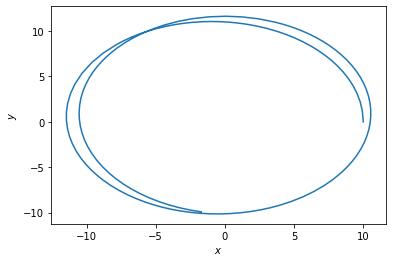

In [20]:
# Set the initial conditions at the turning point,
# which we call phi=0:
y   = np.array([r_init,0.0,0])
tarr= np.array([0])
yarr= np.zeros((1,3))
yarr[0,:] = y
#
# First integrate this using a "normal" integrator.
# If you try this without adapative step sizes then
# you'll find the integration goes haywire.  We'll
# use our ode23 example above.
#
t,dt = tarr[0],0.1
k1   = dt*deriv(t,y)
while t<500.0:
    tnew,ynew,znew,k1new = ode23(t,y,dt,k1)
    tol = abstol + np.max([np.abs(ynew),np.abs(znew)]) * reltol
    err = np.max(np.abs(ynew-znew)) + 1e-30
    if err<tol:
        t,y,z,k1 = tnew,ynew,znew,k1new
        if err<0.2*tol:
            # If we're doing too well, allow step to grow.
            fac = np.max([(tol/err)**(0.3333),5.0])
            dt *= fac
            k1 *= fac
    else:
        fac = 0.9*(tol/err)**(0.3333)
        dt *= fac
        k1 *= fac
    tarr = np.append(tarr,t)
    yarr = np.append(yarr,y[None,:],axis=0)
# Plot the orbit.
xx = yarr[:,0]*np.cos(yarr[:,2])
yy = yarr[:,0]*np.sin(yarr[:,2])
#
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(xx,yy)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

*Note* the perhelion "advance" where the orbit doesn't close on itself (here in a somewhat extreme example)!

## To do ##

Systematic generation of higher-order methods.

Operator splitting.

Effective Hamiltonian.  BCH formula (generators to group elements).